# ** Neural Network for Iris Dataset **

NN for the Iris dataset using keras and backpropagation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

from IPython.display import SVG
from keras.utils import model_to_dot
import pydot

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

2.0.0


Using TensorFlow backend.


In [2]:
# Weights and biases to track the hyperparameters
# import wandb
# wandb.init(project="nn-testing")
# from wandb.keras import WandbCallback
# wandb.init(config={"hyper": "parameter"})

In [3]:
iris = load_iris()
X = iris['data'] # array of samples 4 dimensions each describing a feature
y = iris['target'] # array of labels (0, 1, 2)
names = iris['target_names'] # array of labels (0, 1, 2)
feature_names = iris['feature_names'] # ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray() # Y is output of 3 dimensions now, one hot encoding

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=2)
print("X_train shape = {}".format(X_train.shape))
print("Y_train shape = {}".format(Y_train.shape))
print("X_test shape = {}".format(X_test.shape))
print("Y_test shape = {}".format(Y_test.shape))

n_features = X.shape[1]
n_classes = Y.shape[1]

X_train shape = (120, 4)
Y_train shape = (120, 3)
X_test shape = (30, 4)
Y_test shape = (30, 3)


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [4]:
def build_model():
    model = keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


## Train the full model

#### Epochs
This is the number of times the network trains forwards and backwards, we will leave this as a high number as we implement early stopping.

#### History
History saves the model fitting data allowing us to plot and visualise it.

#### Validation split
The validation split: If you set the validation_split argument in model.fit to e.g. 0.1, then the validation data used will be the last 10% of the data. Note that the data isn't shuffled before extracting the validation split, so the validation is literally just the last x% of samples in the input you passed. Used to validate as you train.

In [5]:
EPOCHS = 50

history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size = 32, validation_split = 0.2,
                    verbose=0 , callbacks=[ tfdocs.modeling.EpochDots()] )


Epoch: 0, loss:0.6043,  mae:0.5990,  mse:0.6043,  val_loss:0.5912,  val_mae:0.5975,  val_mse:0.5912,  
..................................................

History is a dataframe, we can print the tail of this for the last 5 epochs to see what data we collect at each epoch.

In [6]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
45,0.127124,0.279699,0.127124,0.121766,0.274606,0.121766,45
46,0.123598,0.275712,0.123598,0.118229,0.270971,0.118229,46
47,0.120104,0.271493,0.120104,0.114770,0.267600,0.114770,47
48,0.117009,0.268069,0.117009,0.111487,0.264153,0.111487,48
49,0.113928,0.264285,0.113928,0.108389,0.260972,0.108389,49


We can plot the mean absolute error for the training data and the validation data. When the validation data levels off our model is no longer improving.

Text(0, 0.5, 'MSE')

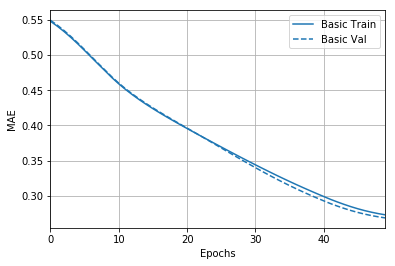

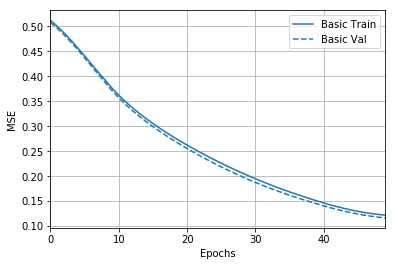

In [7]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE')

plt.figure()
plotter.plot({'Basic': history}, metric = "mse")
# plt.ylim([0, 1])
plt.ylabel('MSE')

## Testing the model

We now used this learnt model to predict outputs using our test inputs.

We note that y_test are the real output values that match the inputs X_test.

In [8]:
test_predictions = model.predict(X_test)
print("test_predictions shape = {}".format(test_predictions.shape))

test_predictions shape = (30, 3)


### Evaluate the model's effectiveness

Now that the model is trained, we can get some statistics on its performance.

Evaluating means determining how effectively the model makes predictions. To determine the model's effectiveness at Iris classification, pass some sepal and petal measurements to the model and ask the model to predict what Iris species they represent. Then compare the model's predictions against the actual label. For example, a model that picked the correct species on half the input examples has an accuracy of 0.5.

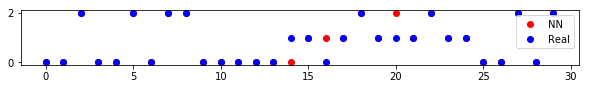

In [9]:
NN_output_args = np.argmax(test_predictions, axis = 1)
real_output_args = np.argmax(Y_test, axis = 1)

plt.figure(figsize = (10,1))
plt.plot(NN_output_args,'ro', label = "NN")
plt.plot(real_output_args, 'bo', label = "Real")
plt.legend()

In [10]:
test_accuracy = tf.keras.metrics.Accuracy()

test_accuracy(NN_output_args, real_output_args)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 90.000%
